<a href="https://colab.research.google.com/github/FabriceBeaumont/1-MA-INF_2314_IPSA_Repo/blob/main/Code/Exercise2/SolutionOfSheet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IPSA 2021 - Exercise 2 - Superpixels and tiling effects



## 0 - Practical advice

In [1]:
import imageio 
import numpy as np
import numpy.random as rnd
import scipy.ndimage as img
import matplotlib.pyplot as plt

import timeit, functools

In [3]:
def imageRead(imgname, pilmode ='L', arrtype=float):
    """
    Read an image file into a numpy array

    imgname: str
        name of image file to be read
    pilmode: str
        for luminance / intesity images use ’L’
        for RGB color images use ’RGB’
    
    arrtype: numpy dtype
        use np.float, np.uint8, ...
    """
    return imageio.imread(imgname, pilmode=pilmode).astype(arrtype)

def imageWrite(arrF, imgname, arrtype=np.uint8):
    """
    Write a numpy array as an image file 
    the file type is inferred from the suffix of parameter imgname, e.g. ’.png’
    arrF: array_like
        array to be written
    imgname: str
        name of image file to be written
    arrtype: numpy dtype
        use np.uint8, ...
    """
    imageio.imwrite(imgname, arrF.astype(arrtype))

## 1 - (Naı̈ve) downsampling

A rather simple idea for how to reduce the resolution of a digital (intensity) image is to keep only every $m$-th row and every $n$-th column of its pixels.

Without using for loops, implement a function downsample with three parameters `arrF`, `m`, and `n` that realizes this manner of downsampling.

In [4]:
def naive_downsampling(arrF, m, n):
    # Only keep every m-th row:     'arrF[::m, :]'
    # Only keep every n-th column:  'arrF[:, ::n]'
    
    # In short
    return arrF[::m,::n]

In [ ]:
# filename = "../Data/portrait.png"
filename = "portrait.png"
arrF = imageRead(filename)

parameters = [(1, 1), (4, 4), (8, 8)]

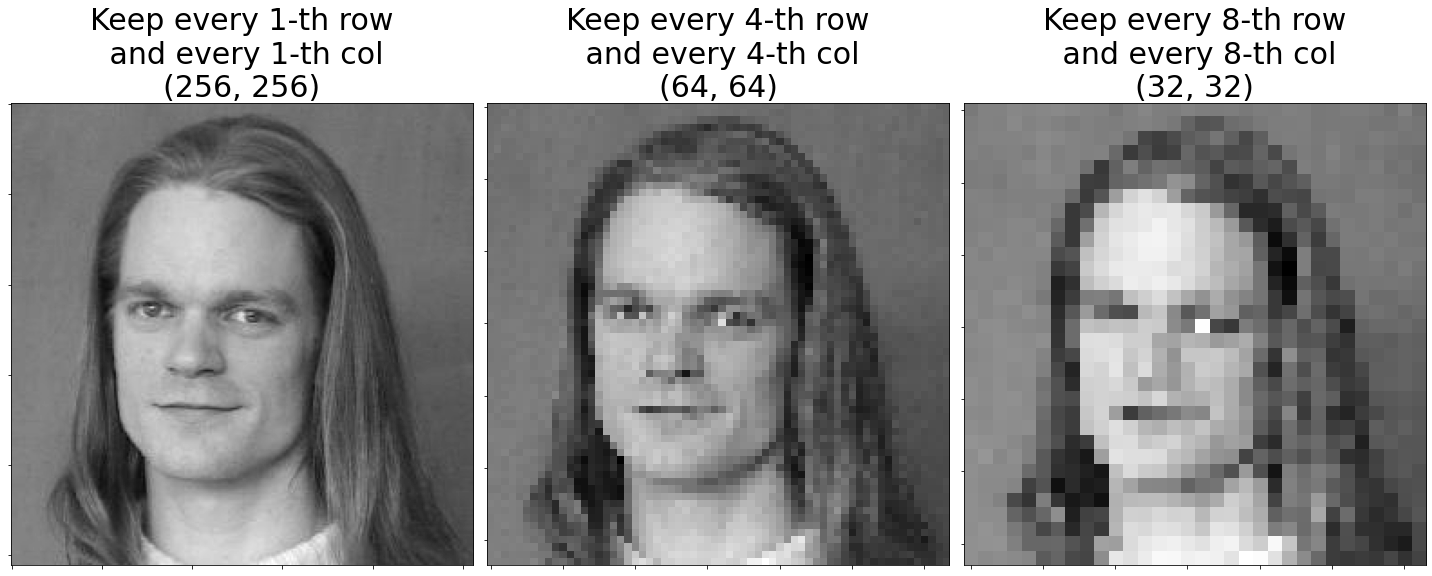

In [ ]:
fig, axs = plt.subplots(1, len(parameters), figsize=(20,20))

for i, (m, n) in enumerate(parameters):
    arrG = naive_downsampling(arrF, m, n)

    ax = axs[i]
    ax.imshow(arrG, cmap='gray')    
    ax.set_title(f"Keep every {m}-th row\n and every {n}-th col\n{arrG.shape}", fontsize=30)
    
    ax.set_xticklabels([]); ax.set_yticklabels([])    
    fig.tight_layout()

## 2 - Kronecker products for (naı̈ve) upsampling

The Kronecker product of an ordered pair of matrices (or 2D *numpy* arrays) $A$, $B$ of sizes $k\times l$ and $m\times n$ respectively is defined as

$$ C=A\otimes B=\begin{bmatrix} a_{1,1} B & a_{1,2} B & \dots & a_{1,l} B \\ 
a_{2,1} B & a_{2,2} B & \dots & a_{2,l} B\\ 
\vdots & \vdots & \ddots & \vdots\\
a_{k,1} B & a_{k,2} B & \dots & a_{k,l} B \end{bmatrix}$$

and therefore produces a matrix (or 2D array) $C$ of size $km\times ln$.

Conveniently, numpy provides the function `np.kron()` for the computation of Kronecker products. This allows us to realize a rather simple idea for upsampling a small (intensity) image: assuming that the given image is
stored in an array $F$, we may simply compute
$$ G = F\otimes O $$
where $O$ denotes an $m\times n$ array of all ones.

Now, without using for loops, implement an appropriately parameterized function upsample. Then, load image `portrait.png` into `arrF` and compute it.

In [5]:
def naive_upsampling(arrF, m, n):
    """ 
    Upsample the matrix by using the Kronecker product
    with a matrix full of ones - thereby reating local
    duplicates of the values in the input matrix.
    """    
    return np.kron(arrF, np.ones((m, n)))

In [ ]:
# filename = "../Data/portrait.png"
filename = "portrait.png"
arrF = imageRead(filename)

parameters = [(1, 1), (2, 2), (4, 4), (8, 8)]

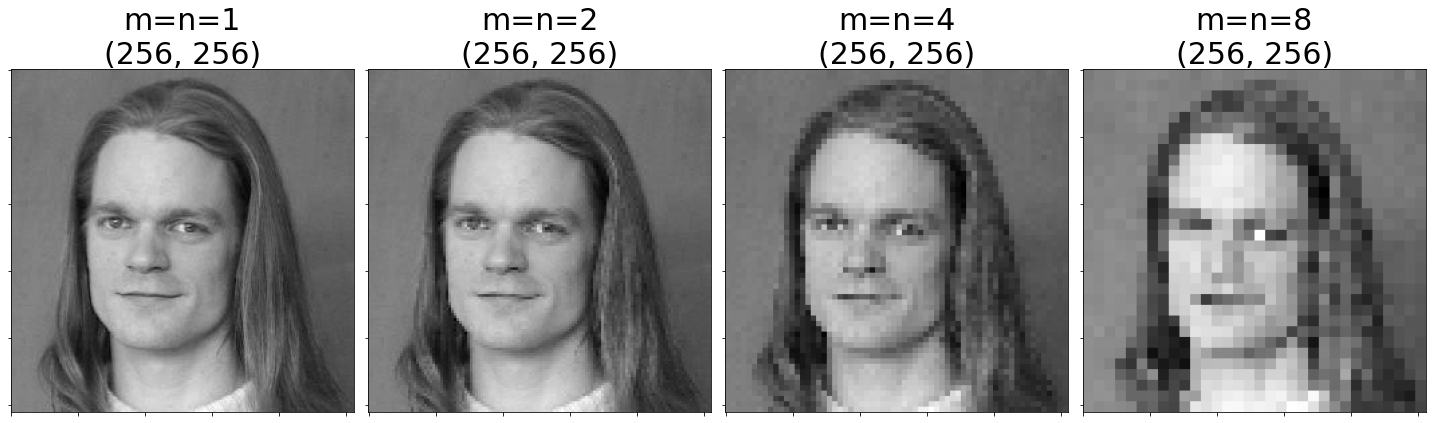

In [ ]:
fig, axs = plt.subplots(1, len(parameters), figsize=(20,20))

for i, (m, n) in enumerate(parameters):
    arrG = naive_upsampling(naive_downsampling(arrF, m, n), m, n)

    ax = axs[i]
    ax.imshow(arrG, cmap='gray')    
    ax.set_title(f"m=n={m}\n{arrG.shape}", fontsize=30)
    ax.set_xticklabels([]); ax.set_yticklabels([])    
    fig.tight_layout()

## 3 - Superpixels (part 1)

In the previous task, we have already seen examples of images composed of superpixels. These are images of size $M\times N$ whose content consists of uniformly colored tiles of size $m\times n$ where $m\ll M$ and $n\ll N$.

In the previous task, the superpixels resulted from (naı̈vely) upsampling a
small image into a larger one. However, superpixels also arise in an image
effect called pixelize (which is often used to render faces unrecognizable).
In this effect, each pixel in each $m\times n$ tile of a given image is set to the average intensity value within the tile.

In [6]:
def meanSuperPixelV1(arrF, m, n):
    M, N = arrF.shape
    arrG = np.zeros((M, N))

    # Iterate through the superpixel rows (stepsize m)
    for i in range(0, M, m):
        # Iterate through the superpixel columns (stepsize n)
        for j in range(0, N, n):
            # Accumulate the intensity in one superpixel
            intensity_avg = 0
            for k in range(m):  
                for l in range(n):
                    intensity_avg += arrF[i+k,j+l]
            # Compute the intensity mean in this superpixel
            intensity_avg /= m*n

            # Use the intensity mean as new value for the complete superpixel
            arrG[i:i+m,j:j+n] = intensity_avg
    return arrG

In [7]:
def meanSuperPixelV2(arrF, m, n):
    M, N = arrF.shape
    arrG = np.zeros((M, N))

    # Iterate through the superpixel rows (stepsize m)
    for i in range(0, M, m):
        # Iterate through the superpixel columns (stepsize n)
        for j in range(0, N, n):
            # Use the intensity mean in the superpixel as its new value everywhere
            arrG[i:i+m,j:j+n] = np.mean(arrF[i:i+m,j:j+n])
    return arrG

In [8]:
def meanSuperPixelV3(arrF, m, n):
    M, N = arrF.shape
    arrG = np.reshape(arrF, (M*N//n, n))
    arrG = np.mean(arrG, axis=1)
    arrG = np.reshape(arrG, (M,N//n))
    arrH = np.reshape(arrG, (m, (M//m)*(N//n)), 'F')
    arrH = np.mean(arrH, axis=0)
    arrH = np.reshape(arrH, (M//m, N//n), 'F')
    return np.kron(arrH, np.ones((m,n)))

In [9]:
def meanSuperPixelV4(arrF, m, n):
    M, N = arrF.shape
    
    # Accumulate the repeated row-values in the superpixel
    # buy reducing the total column count. Then compute the mean.
    arrA = np.add.reduceat(arrF, np.arange(0,N,n), axis=1) / n
    # Do the same for the columns
    arrB = np.add.reduceat(arrA, np.arange(0,M,m), axis=0) / m
    # Now expand the image by duplicating the array of means - 
    # recreating superpixels with the mean as only value.
    arrC = np.repeat(arrB, n, axis=1)
    arrD = np.repeat(arrC, m, axis=0) 
    
    return arrD

In [10]:
def meanSuperPixelV5(arrF, m, n):
    M, N = arrF.shape

    # Accumulate the repeated row-values in the superpixel
    # buy reducing the total column count. Then compute the mean.
    arrG = np.add.reduceat(arrF, np.arange(0,N,n), axis=1) / n
    # Do the same for the columns
    arrH = np.add.reduceat(arrG, np.arange(0,M,m), axis=0) / m
    
    # Now expand the image by duplicating the array of means - 
    # recreating superpixels with the mean as only value.
    return np.kron(arrH, np.ones((m,n)))

Lets test these implementations.

In [19]:
# filename = "../Data/portrait.png"
filename = "portrait.png"
arrF = imageRead(filename)

methods = [meanSuperPixelV1, meanSuperPixelV2, meanSuperPixelV3, meanSuperPixelV4, meanSuperPixelV5]
parameters = [(8, 8)]

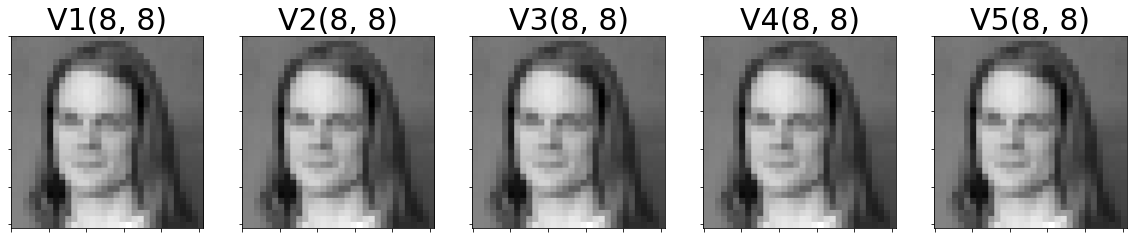

In [34]:
fig, axs = plt.subplots(len(parameters), len(methods), figsize=(20,20))

for c, method in enumerate(methods):
    for r, (m, n) in enumerate(parameters):
        arrG = method(arrF, m, n)

        ax = axs[c]
        ax.imshow(arrG, cmap='gray')    
        ax.set_title(f"{method.__name__[-2:]}({m}, {n})", fontsize=30)
        ax.set_xticklabels([]); ax.set_yticklabels([])    
        # fig.tight_layout()

#### Task: 
Letting $m = n = 8$, perform runtime measurements for the above four methods on `portrait.png`.

In [11]:
def runtime_evaluation(data, m, n, methods, nRep, nRun):
    print("Mean runtimes for:")
    for method in methods:
        ts = timeit.Timer(functools.partial(method, data, 8, 8)).repeat(nRep, nRun)
        print(f"{method.__name__}:\t{min(ts) / nRun}\t[sec]")

In [12]:
methods = [meanSuperPixelV1, meanSuperPixelV2, meanSuperPixelV3, meanSuperPixelV4, meanSuperPixelV5]
nRep    = 3
nRun    = 100
n = m   = 8

#filename0 = "../Data/portrait.png"
filename0 = "portrait.png"
arrF = imageRead(filename0)

In [13]:
runtime_evaluation(arrF, m, n, methods, nRep, nRun)

Mean runtimes for:
meanSuperPixelV1:	0.027032539110000472	[sec]
meanSuperPixelV2:	0.01577511231000017	[sec]
meanSuperPixelV3:	0.0007753210499993202	[sec]
meanSuperPixelV4:	0.0002625213299995721	[sec]
meanSuperPixelV5:	0.0006022175099997185	[sec]


## 4 - Superpixels (part 2)

Instead of working with the mean intensity value in each $m\times n$ tile of an
image, we can also pixelize by using median intensities.

Implement a function `medianSuperPixel` simply by replacing `np.mean()`
in `meanSuperPixelV2` with `np.median()`.


In [ ]:
def medianSuperPixel(arrF, m, n):
    M, N = arrF.shape
    arrG = np.zeros((M, N))

    # Iterate through the superpixel rows (stepsize m)
    for i in range(0, M, m):
        # Iterate through the superpixel columns (stepsize n)
        for j in range(0, N, n):
            # Use the intensity median in the superpixel as its new value everywhere
            arrG[i:i+m,j:j+n] = np.median(arrF[i:i+m,j:j+n])
    return arrG

For $(m, n) \in \{ (4, 4), (32, 32), (16, 32), (32, 16)\}$, run `meanSuperPixelV2`
and `medianSuperPixel` on `portrait.png`.

In [ ]:
#filename = "../Data/portrait.png"
filename = "portrait.png"
arrF = imageRead(filename)

parameters = [(4, 4), (32, 32), (16, 32), (32, 16)]

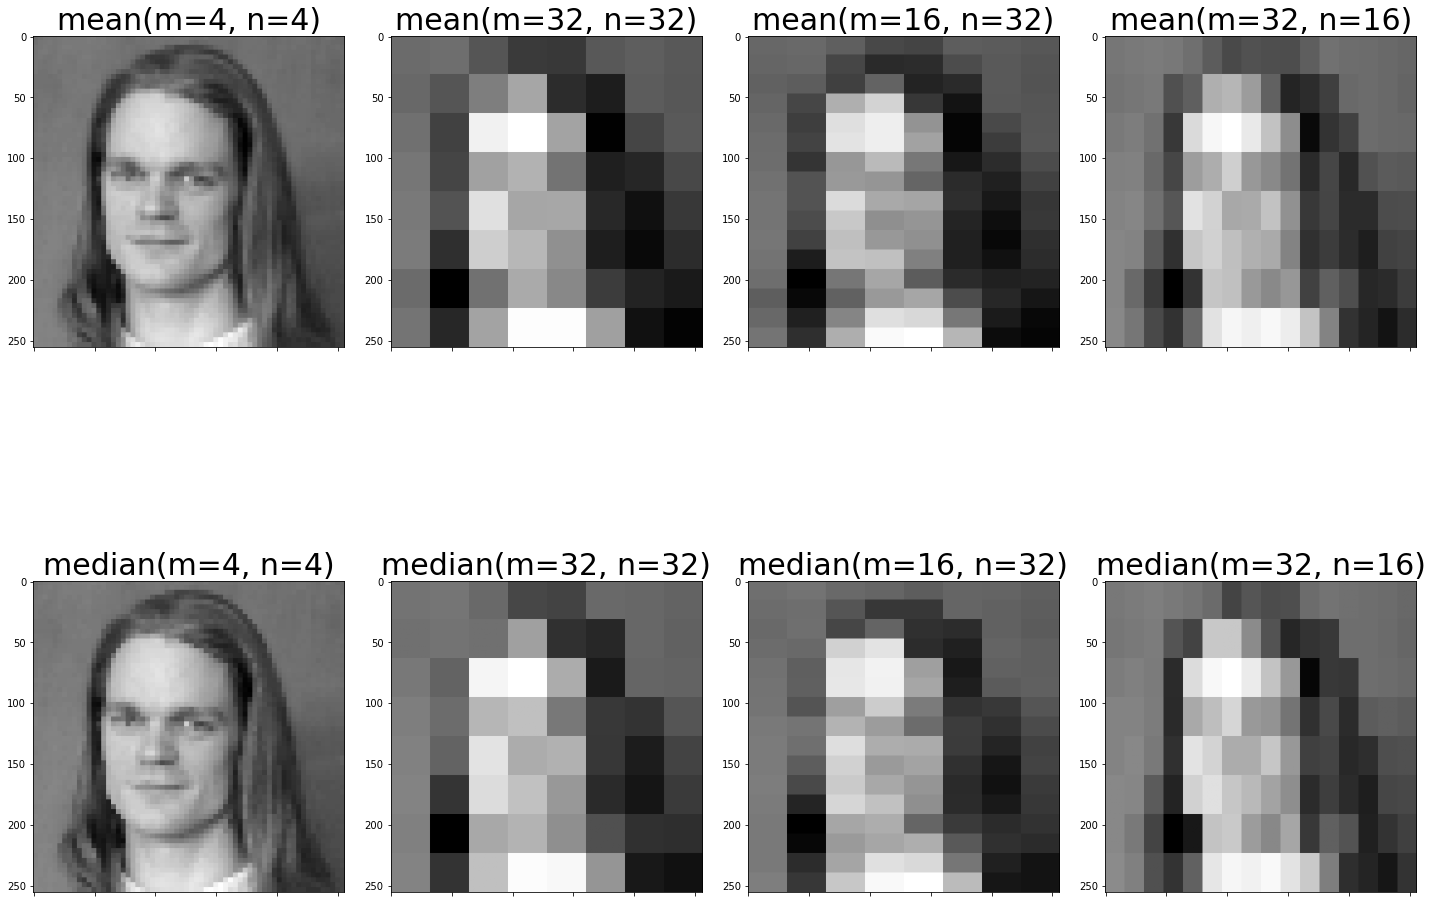

In [ ]:
fig, axs = plt.subplots(2, len(parameters), figsize=(20,20))

for i, (m, n) in enumerate(parameters):
    # Execute the superpixel creations
    arrG_mean = meanSuperPixelV2(arrF, m, n)
    arrG_median = medianSuperPixel(arrF, m, n)

    # Arrange the meanSuperPixelV2-image
    ax_mean = axs[0, i]
    ax_mean.imshow(arrG_mean, cmap='gray')    
    ax_mean.set_title(f"mean(m={m}, n={n})", fontsize=30)
    ax_mean.set_xticklabels([]); ax.set_yticklabels([])

    # Arrange the medianSuperPixel-image
    ax_median = axs[1, i]
    ax_median.imshow(arrG_median, cmap='gray')    
    ax_median.set_title(f"median(m={m}, n={n})", fontsize=30)
    ax_median.set_xticklabels([]); ax.set_yticklabels([])

    fig.tight_layout()

## 5 - Why do we always work with small images?

Some of you may wonder why the example images we consider in these exercises are always rather small (say of resultion $256\times 256$ pixels)...
To make a long story short, this is in order not to tax your patience. We already
saw that large images take longer to process. Just for the fun it, let us
therefore test your patience and pixelize a larger color image.

The image `bauckhage.jpg`  has a resolution of $4068 \times 2712$ pixels and is therefore still of moderate size given present day standards. Read this color image into a numpy array `arrF`, run `medianSuperPixel` on each of its color layers, and write your result as a PNG image. 

Experiment with different tile sizes
$m\times n$.

In [ ]:
#filename = "../Data/bauckhage.jpg"
filename = "bauckhage.jpg"

arrF = imageRead(filename, pilmode='RGB')

In [ ]:
parameters = [(32, 32), (64, 64), (128, 128)]

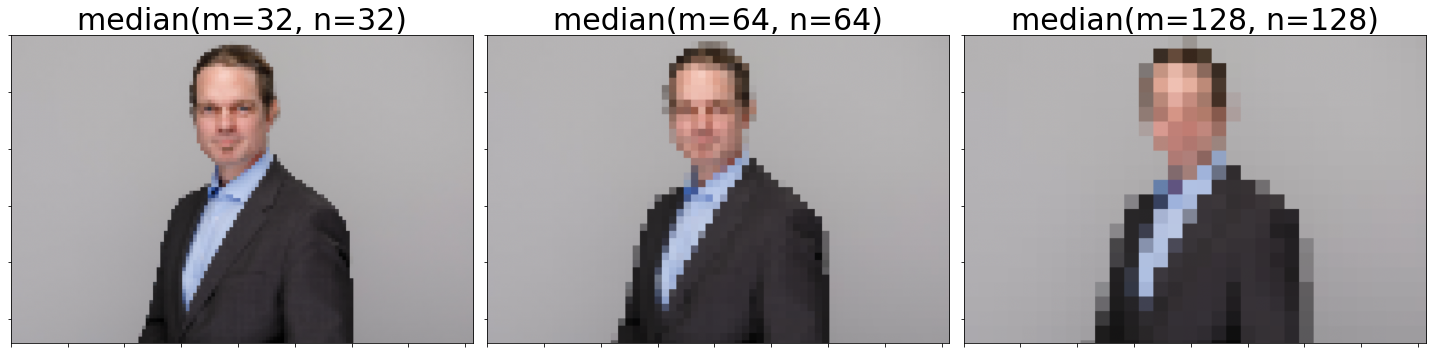

In [ ]:
fig, axs = plt.subplots(1, len(parameters), figsize=(20,20))

for i, (m, n) in enumerate(parameters):
    ax = axs[i] if len(parameters) > 1 else axs

    # Iterate through the color channels
    for c in range(3):
        # Call the 'medianSuperPixel'-function on each color channel
        arrF[:, :, c] = medianSuperPixel(arrF[:,:,c], m, n)
    
    # Arrange the results in one figure
    ax.set_title(f"median(m={m}, n={n})", fontsize=30)
    ax.imshow(arrF / 255)
    ax.set_xticklabels([]); ax.set_yticklabels([])

    fig.tight_layout()

## 6 - “Simple” tiling effects

Speaking of tiles of size $m\times n$, can you think of a piece of code that creates
images where tiles of the original image have been moved around randomly?

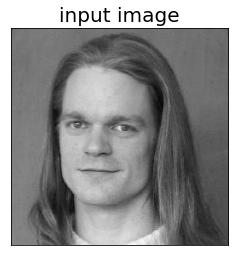

In [ ]:
# filename = "../Data/portrait.png"
filename = "portrait.png"

arrF = imageRead(filename)

plt.imshow(arrF, cmap='gray')
plt.title(f"input image", fontsize=20)
plt.xticks([]); plt.yticks([])
plt.show()

#### Fully vectorized implementation

In [37]:
def shifted_rect_tiles(arrF, m=8, n=8, dymax=15, dxmax=15):
    """
    Neat implementation without any for-loops.

    arrF : 2D array, input intensity image
    m    : int, vertical tile size
    n    : int, horizontal tile size
    dymax: int, maximum vertical tile displacement
    dxmax: int, maximum horizontal tile displacement
    """

    # Determine size of input image
    M, N = arrF.shape

    # Initialize output image
    arrG = np.zeros((M,N))

    # Initialize an array of all ones
    arrO = np.ones ((m,n)).astype(int)

    # Compute number of tile rows and columns
    numy, numx = M//m, N//n

    # Compute offset values needed in case that
    # m and n are not proper divisors of M and N
    offy = (M % m) // 2 if (M % m) != 0 else 0
    offx = (N % n) // 2 if (N % n) != 0 else 0
    
    # Compute coordinate arrays of size (m*numy, n*numx)
    xs, ys = np.meshgrid(np.arange(n*numx) + offx, np.arange(m*numy) + offy)

    # Compute (numy, numx) arrays of random shift
    # values in [-dxmax, dxmax] and [-dymax, dymax] 
    dx = rnd.randint(-dxmax, dxmax+1, (numy, numx))
    dy = rnd.randint(-dymax, dymax+1, (numy, numx))

    # Upsample these arrays to size (m*numy, n*numx)
    dx = np.kron(dx, arrO)
    dy = np.kron(dy, arrO)

    # Compute shifted coordinate arrays of size (m*numy, n*numx)
    # and safeguard againts coordinates outside of image domain
    us = np.clip(xs+dx, 0, N-1)
    vs = np.clip(ys+dy, 0, M-1)

    # Compute shifted tile image 
    arrG[vs,us] = arrF[ys,xs]

    return arrG

In [41]:
tile_size_paris = [(8, 8), (32, 32), (32, 7)]

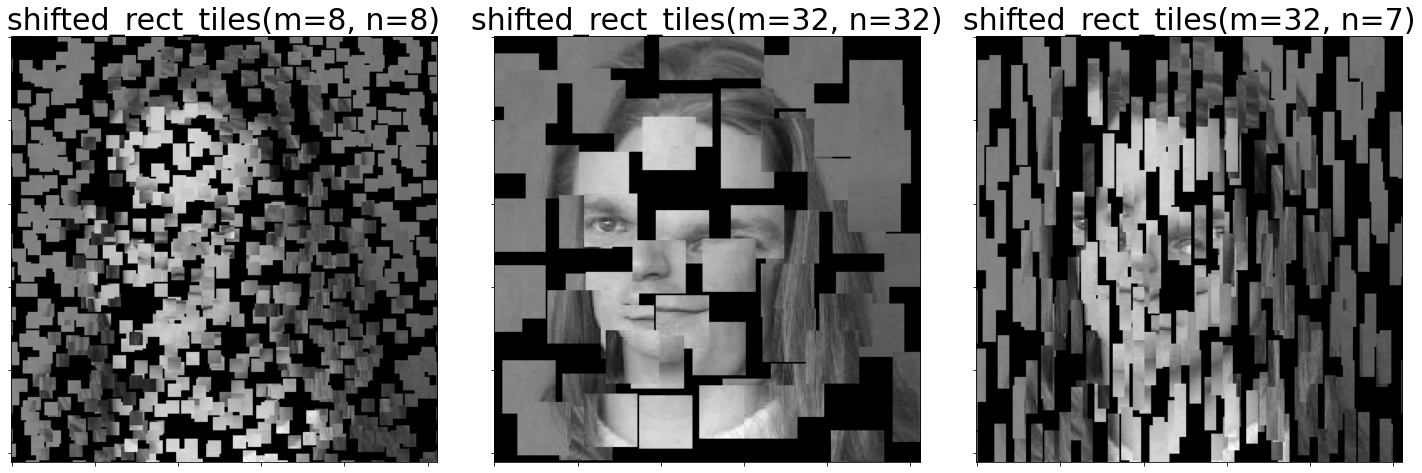

In [42]:
fig, axs = plt.subplots(1, len(tile_size_paris), figsize=(20,20))

for i, (m, n) in enumerate(tile_size_paris):
    # Execute the tile cutter
    arrG = shifted_rect_tiles(arrF, m, n)

    # Arrange the result
    ax = axs[i]
    ax.imshow(arrG, cmap='gray')    
    ax.set_title(f"shifted_rect_tiles(m={m}, n={n})", fontsize=30)
    ax.set_xticklabels([]); ax.set_yticklabels([])

    fig.tight_layout()

#### Another (less beautiful) implementation

In [ ]:
def cut_into_tiles(arrF, tile_size_m=8, tile_size_n=8, offset_strength_m=1, offset_strength_n=1):
	"""
	Offset every tile by some random margin.
	Allow the tiles to leave the border, by first placing them
	on a larger image, which is then cut down.
	"""
	M, N = arrF.shape
	# Enlarge the canvas in order to freely place the tiles
	max_offset_m = int(offset_strength_m * tile_size_m)
	max_offset_n = int(offset_strength_n * tile_size_n)
	
	# Enlarge the canvas in order to freely place the tiles
	arrG_M = M + 2 * max_offset_m
	arrG_N = N + 2 * max_offset_n
	arrG = np.zeros((arrG_M, arrG_N))

	# Iterate over the image in tiled step size
	for i in range(0, M - tile_size_m, tile_size_m):
		for j in range(0, N - tile_size_n, tile_size_n):

			# Initialize a random offset strength of the current tile
			# Offset value 'max_offset_m' and 'max_offset_n' would yield in no offset,
			# since the target canvas is bigger by this amount!
			io = i + max_offset_m + rnd.randint(-max_offset_m, max_offset_m)
			jo = j + max_offset_n + rnd.randint(-max_offset_n, max_offset_n)
		
			# Cut the tile and place it with the offset in the returned image
			if arrF[i:i + tile_size_m, j:j + tile_size_n].shape != arrG[io:io + tile_size_m, jo:jo + tile_size_n].shape:
				print("Test")
		
			arrG[io:io + tile_size_m, jo:jo + tile_size_n] = arrF[i:i + tile_size_m, j:j + tile_size_n]

	# Cut down the enlarged canvas to the original size
	return arrG[max_offset_m:-max_offset_m, max_offset_n:-max_offset_n]

In [40]:
tile_size_paris = [(8, 8), (32, 32), (32, 7)]
offset_strength_m = 0.8
offset_strength_n = 0.8

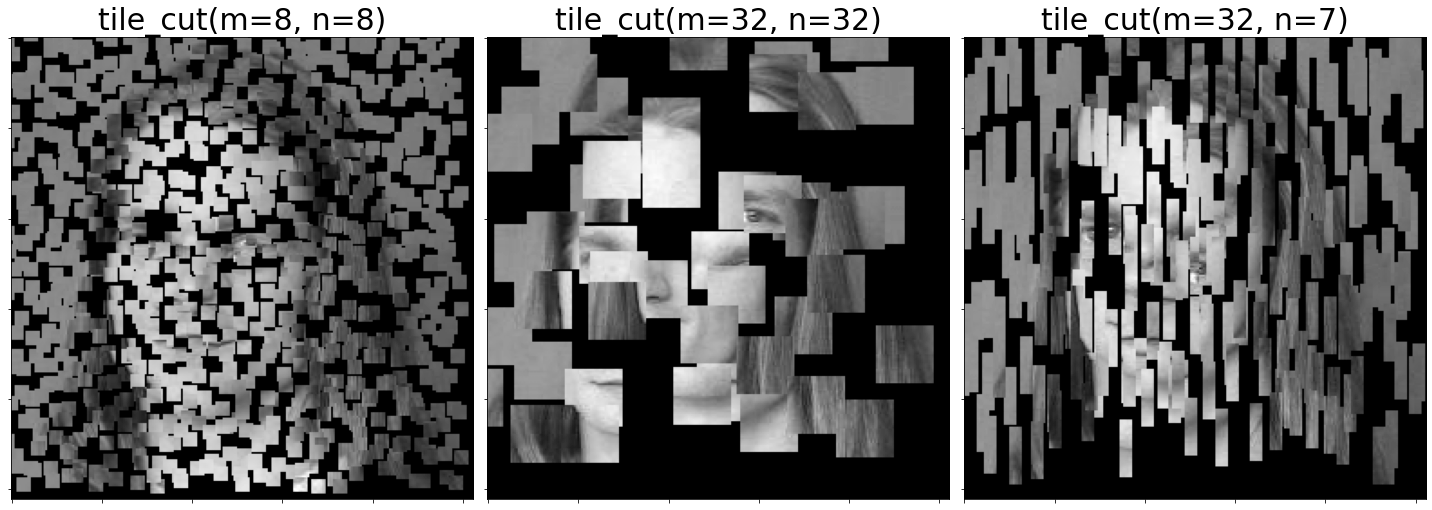

In [ ]:
fig, axs = plt.subplots(1, len(tile_size_paris), figsize=(20,20))

for i, (m, n) in enumerate(tile_size_paris):
    # Execute the tile cutter
    arrG = cut_into_tiles(arrF, m, n, offset_strength_m, offset_strength_m)

    # Arrange the result
    ax = axs[i]
    ax.imshow(arrG, cmap='gray')    
    ax.set_title(f"tile_cut(m={m}, n={n})", fontsize=30)
    ax.set_xticklabels([]); ax.set_yticklabels([])

    fig.tight_layout()

## 7 - Outer Products

The outer product of an ordered pair of vectors (or 1D numpy arrays) $x$, $y$
of sizes $m$ and $n$ respectively is the Kronecker product of $x$ and $y^\intercal$

$$ Z=x\otimes y^\intercal = \begin{bmatrix} x_1 y^\intercal \\
x_2 y^\intercal\\
\vdots\\ 
x_m y^\intercal\end{bmatrix} 
= \begin{bmatrix} x_1 y_1 & x_1 y_2 & \dots & x_1 y_n \\
x_2 y_1 & x_2 y_2 & \dots & x_2 y_n \\
\vdots & \vdots & \ddots & \vdots \\
x_m y_1 & x_m y_2 & \dots & x_m y_n \\\end{bmatrix}
$$
and therefore produces a matrix (or 2D array) $Z$ of size $m\times n$.

Note that we typically write the vector outer product $x\otimes y^\intercal$ as $xy^\intercal$ and that the entries of $Z$ are given by $z_{i,j} = x_{i} y_{j}$.

Conveniently, numpy provides the function `np.outer()` for the computation of outer products of vectors (or 1D arrays). This will come in handy later in this course. 

In [ ]:
sigma = 5.
msize = int(np.ceil(sigma * 2.575) * 2 + 1)

xs      = np.arange(msize)
vecG    = np.exp(-0.5 * ((xs-msize/2) / sigma)**2).reshape(msize,1)
vecG   /= np.sum(vecG)

In [ ]:
print(vecG.shape)

(27, 1)


##### Outer product:

In [ ]:
matG  = np.outer(vecG, vecG)
matG /= np.sum(matG)

In [ ]:
print(matG.shape)

(27, 27)


**Note**: There is a difference between the outer product of two vectors and the Kronecker product of two vectors. To see this difference for yourself:

##### Kronecker product:

In [ ]:
vecH  = np.kron(vecG, vecG)
vecH /= np.sum(vecH)

In [ ]:
print(vecH.shape)

(729, 1)


In [ ]:
27 * 27

729

##### Vector and matrix to image:

In [ ]:
# https://numpy.org/doc/stable/reference/generated/numpy.interp.html
arrg = np.interp(vecG, (vecG.min(), vecG.max()), (0, 255))
arrG = np.interp(matG, (matG.min(), matG.max()), (0, 255))

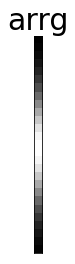

In [ ]:
plt.imshow(arrg, cmap='gray')    
plt.title(f"arrg", fontsize=30)
plt.xticks([]); plt.yticks([])
plt.show()

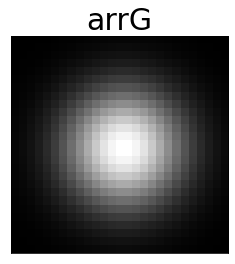

In [ ]:
plt.imshow(arrG, cmap='gray')    
plt.title(f"arrG", fontsize=30)
plt.xticks([]); plt.yticks([])
plt.show()

#### Can you “see” what you just computed? That is, do you recognize what the two images visualize?

`arrg` visualizes the values in the vector `vecG`. `arrG` visualizes the values in the matrix `matG` which is the outer product of `vecG` and itself. Thus `arrG` visualizes the **covariance matrix** of `vecG`.